In [50]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
using JLD

In [2]:
using Plots

### Configuration setup

In [30]:
# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset, U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.0, 2.0, length=100)

t0 = 0.0
tf = 8.0
tspan = (t0, tf)

(0.0, 8.0)

### Generate the truth used in the twin experiment

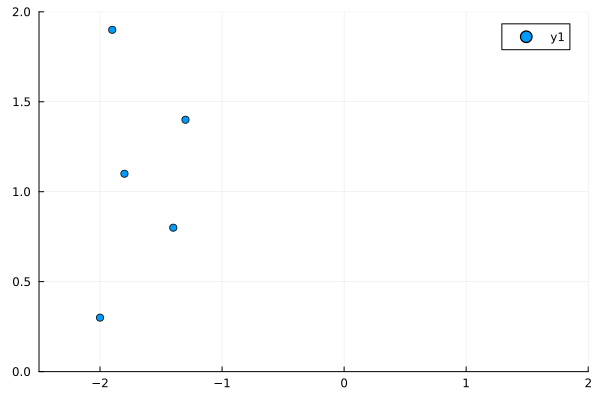

In [4]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [64]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = (blobs₊, blobs₋)

#data = generate_data_twin_experiment(deepcopy(sys), t0, tf, config_data, "./data/");
tt, x0, xt, yt = load("./data/data_twin_experiment.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  7.9910000000000005, 7.992, 7.993, 7.994, 7.995, 7.996, 7.997, 7.998, 7.9990000000000006, 8.0], 0.001, [-2.0210843826154914, 0.2729954217291385, 0.3939549906027909, -1.8730198563959952, 1.88530449002997, 0.4049735878425253, -1.8632862286555847, 1.1286461764560032, 0.4496040781853021], [-2.0209703169220736 -2.0198774364346805 … 7.907907590156307 7.908921172889714; 0.27293294709678867 0.27303644284453066 … 0.4581285088788024 0.4583205792271706; … ; 1.1286163237108338 1.1285749563804197 … 1.437036677149462 1.4371571270781436; 0.4495053657299518 0.4495175949913126 … 0.44095723672175285 0.44102124903006784], [-0.5040484798051709 -0.4956570003274523 … -0.5107452168066264 -0.4867538494363436; -0.494905390648114 -0.4967378459370895 … -0.4869156677009938 -0.4874499807669399; … ; -0.5221344320768722 -0.4787325518364323 … -0.4844836908458061 -0.49754555761644254; -0.4900593414515342 -0.510717891696

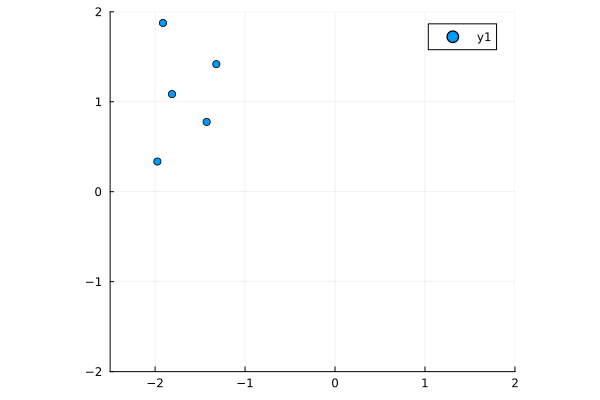

In [65]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

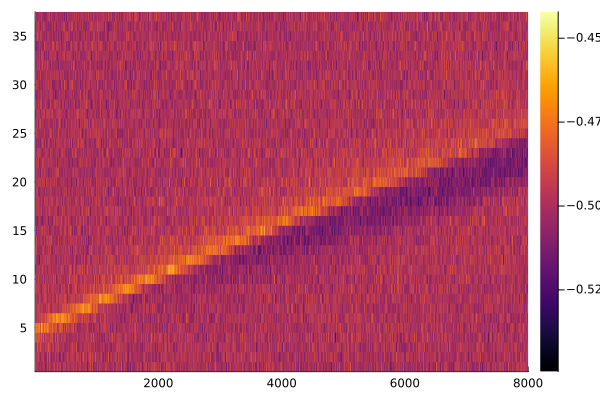

In [66]:
heatmap(data.yt)

### Setup the sequential filter

In [67]:
config = deepcopy(config_data)

VortexConfig{Nothing, Vector{ComplexF64}}(5, nothing, 1.0 + 0.0im, ComplexF64[-2.0 + 0.0im, -1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im  …  11.5 + 0.0im, 12.0 + 0.0im, 12.5 + 0.0im, 13.0 + 0.0im, 13.5 + 0.0im, 14.0 + 0.0im, 14.5 + 0.0im, 15.0 + 0.0im, 15.5 + 0.0im, 16.0 + 0.0im], 0.001, 0.1, 0.0001, 0.0001, 1.0, 0.01, true)

In [68]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [69]:
enkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

LREnKF  with filtered = true


In [70]:
Ne = 8
ratio = 0.95
Nx = 3*config.Nv
Ny = length(config.ss)

# Generate initial condition
X0 = zeros(Ny+Nx, Ne)
zv = zeros(ComplexF64, Nv);
for l=1:Ne
    for i=1:Nclusters
        for j=1:Nset
            zij = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 1, l] = real(zij)
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 2, l] = imag(zij)
        end
    end
end

Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]

for l = 1:Ne
    for i=1:Nclusters
        for j=1:Nset
            Γij = signclusters[i]*abs.((0.4 + 0.1*randn()))
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 3, l] = Γij
        end
    end
end

### LREnKf

In [78]:
Xflr_non, Xalr_non = lowrankenkf_symmetric_vortexassim(lrenkf, 
                                                       deepcopy(X0), 
                                                       tspan, config, 
                                                       data;                                                              
                                                       withfreestream  = true, 
                                                       P = serial);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [79]:
mean(Xflr_non[end],dims=2)

15×1 Matrix{Float64}:
      1.0187293595954376e10
   5865.74987480678
      0.00848992856043795
      2.1793843337300564e10
      0.01942642563311364
      0.008674953609271849
      7.142263534875175e10
      0.018821774736065798
      0.007135489379818768
     -2.9496404388824623e10
      1.410699343827168e6
 632330.5609982727
     -5.380031620362657e9
      0.016233833738735097
      0.008652243003407629

### Adaptive LREnKf

In [82]:
Xflowrank, Xalowrank, rxhist, ryhist = adaptive_lowrankenkf_symmetric_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data; 
                                                             isadaptive = true,
                                                             withfreestream  = true, 
                                                             ratio = 0.95, P = serial);

In [83]:
mean(Xflowrank[end],dims=2)

15×1 Matrix{Float64}:
 8.385979853066118
 0.34552206949630726
 0.3552155130066204
 6.120802114387938
 1.375332930140945
 0.2583601227940624
 8.26165385596393
 1.1700608084740525
 1.003684662938288
 6.4558911483763
 1.652014783743523
 0.005982932432838433
 9.261828597219994
 1.7679547462667407
 0.39612816077633084

### sEnKf

In [84]:
Xf, Xa = senkf_symmetric_vortexassim(enkf, 
                                    deepcopy(X0), 
                                    tspan, config, 
                                    data;                                                             
                                    withfreestream  = true, 
                                    P = serial);

In [85]:
mean(Xf[end],dims=2)

15×1 Matrix{Float64}:
     -1.4237206446484411e10
 429887.8427839355
 417633.87361458974
      7.870443708100673e9
 821072.1007635295
 449780.0081946212
      3.843504099513385e12
   4673.444967510384
      9.65781039578535e8
      7.410944428571016e8
   2253.7391308231327
      0.12655766265881332
      9.882849715750628e9
    166.63457322621298
      8.636187692012571

### Localized sEnKf

In [86]:
Lxy, Lyy = 0.01, 0.01
Xfloc, Xaloc = localized_senkf_symmetric_vortexassim(enkf, Lxy, Lyy,
                                    deepcopy(X0), 
                                    tspan, config, 
                                    data;                                                             
                                    withfreestream  = true, 
                                    P = serial);

In [87]:
mean(Xfloc[end],dims=2)

15×1 Matrix{Float64}:
 8.61922997701929
 0.7432995445424175
 0.41886321177551583
 6.971308575495552
 0.9338489552795579
 0.3568902763737213
 7.793207822982167
 1.1225814445319229
 0.3839883386648211
 6.726956589855789
 1.1921717082367873
 0.3704513554384387
 6.75005440559077
 1.4737373521799175
 0.3472506179014657